In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
# from pennylane import numpy as np
import pennylane as qml # import pennylane as qml
import cmath
from numpy.linalg import eig

In [3]:
from functools import reduce
from typing import Iterable

import numpy as np
from scipy import sparse

import pennylane as qml
from pennylane import math, wires
from pennylane.operation import Tensor
from pennylane.ops import Hamiltonian, Identity, PauliX, PauliY, PauliZ, prod, s_prod

I = "I"
X = "X"
Y = "Y"
Z = "Z"

op_map = {
    I: Identity,
    X: PauliX,
    Y: PauliY,
    Z: PauliZ,
}

op_to_str_map = {
    Identity: I,
    PauliX: X,
    PauliY: Y,
    PauliZ: Z,
}

matI = np.eye(2)
matX = np.array([[0, 1], [1, 0]])
matY = np.array([[0, -1j], [1j, 0]])
matZ = np.array([[1, 0], [0, -1]])

mat_map = {
    I: matI,
    X: matX,
    Y: matY,
    Z: matZ,
}

sparse_matI = sparse.eye(2, format="csr")
sparse_matX = sparse.csr_matrix([[0, 1], [1, 0]])
sparse_matY = sparse.csr_matrix([[0, -1j], [1j, 0]])
sparse_matZ = sparse.csr_matrix([[1, 0], [0, -1]])

sparse_mat_map = {
    I: sparse_matI,
    X: sparse_matX,
    Y: sparse_matY,
    Z: sparse_matZ,
}

_map_I = {
    I: (1, I),
    X: (1, X),
    Y: (1, Y),
    Z: (1, Z),
}
_map_X = {
    I: (1, X),
    X: (1, I),
    Y: (1.0j, Z),
    Z: (-1.0j, Y),
}
_map_Y = {
    I: (1, Y),
    X: (-1.0j, Z),
    Y: (1, I),
    Z: (1j, X),
}
_map_Z = {
    I: (1, Z),
    X: (1j, Y),
    Y: (-1.0j, X),
    Z: (1, I),
}

mul_map = {I: _map_I, X: _map_X, Y: _map_Y, Z: _map_Z}

In [4]:
# Pauli Matries

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0,complex(0,1)],[-complex(0,1),0]])

gate_array = [Id,X,Y,Z]

In [35]:
N = 4
qubits = int(np.sqrt(N))

array = np.random.randint(10, size=(N, N))
print(array)
l, v = eig(array)
print(l)

[[5 4 1 4]
 [3 3 3 6]
 [6 4 5 8]
 [5 8 9 4]]
[19.68632047+0.j         1.26242975+1.2031351j  1.26242975-1.2031351j
 -5.21117998+0.j       ]


In [36]:
counter = 0
combination = gate_array

while counter < np.log2(len(array)) - 1:

    combination = np.kron(combination, gate_array)
    
    counter += 1

In [37]:
final_array = np.zeros((len(array),len(array)), dtype=complex)
coeff = np.zeros((len(array)**2), dtype=complex)

for i in range(len(combination)):
    coeff[i] =  1/(len(array)) * np.matrix.trace(np.matmul(array,combination[i]))
    final_array +=  coeff[i] * combination[i]

In [38]:
print(final_array == array) # ensures math

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


In [39]:
print(coeff == 0) # visually checks for 0

[False False  True False False False  True False False False False False
 False False False False]


In [40]:
# Removes zero terms
import itertools
from itertools import product
decomp = []

gate_names = list(product('IXYZ', repeat = int(np.sqrt(len(array)))))
c_final = [i for i in coeff if i != 0]
gate_final = [combination[i] for i in range(len(coeff)) if coeff[i] != 0]
gate_names_used = [gate_names[i] for i in range(len(coeff)) if coeff[i] != 0]

for k in range(len(c_final)):
    decomp.append(c_final[k]*gate_final[k])

In [41]:
gate_names_used

[('I', 'I'),
 ('I', 'X'),
 ('I', 'Z'),
 ('X', 'I'),
 ('X', 'X'),
 ('X', 'Z'),
 ('Y', 'I'),
 ('Y', 'X'),
 ('Y', 'Y'),
 ('Y', 'Z'),
 ('Z', 'I'),
 ('Z', 'X'),
 ('Z', 'Y'),
 ('Z', 'Z')]

In [42]:
obs1 = []

for i in range(len(gate_final)):
    obs1.append(qml.Hermitian(gate_final[i], wires=[0, 1]))

H1 = qml.Hamiltonian((c_final), (obs1))

print(i)
print(H1)

13
  ((-2.5+0j)) [Hermitian0,1]
+ ((-1.75+0j)) [Hermitian0,1]
+ ((-0.5+0j)) [Hermitian0,1]
+ ((-0.25+0j)) [Hermitian0,1]
+ (1.75j) [Hermitian0,1]
+ (0.5j) [Hermitian0,1]
+ (0.75j) [Hermitian0,1]
+ (-0.5j) [Hermitian0,1]
+ ((0.25+0j)) [Hermitian0,1]
+ ((0.75+0j)) [Hermitian0,1]
+ ((4+0j)) [Hermitian0,1]
+ ((4.25+0j)) [Hermitian0,1]
+ ((5.25+0j)) [Hermitian0,1]
+ ((6+0j)) [Hermitian0,1]


In [13]:
# Something is wrong with the order of the kernals

from functools import reduce, singledispatch
from itertools import product
from operator import matmul
from typing import Union

import numpy as np

from pennylane.operation import Tensor
from pennylane.ops import Hamiltonian, Identity, PauliX, PauliY, PauliZ, Prod, SProd, Sum

from pennylane.pauli.pauli_arithmetic import I, PauliSentence, PauliWord, X, Y, Z, mat_map, op_map
from pennylane.pauli import is_pauli_word
# from pennylane.utils import is_pauli_word

def pauli_decomp(
    H, hide_identity=False, wire_order=None, pauli=False) -> Union[Hamiltonian, PauliSentence]:
    r"""Decomposes a Hermitian matrix into a linear combination of Pauli operators.

    Args:
        H (array[complex]): a Hermitian matrix of dimension :math:`2^n\times 2^n`.
        hide_identity (bool): does not include the Identity observable within
            the tensor products of the decomposition if ``True``.
        wire_order (list[Union[int, str]]): the ordered list of wires with respect
            to which the operator is represented as a matrix.
        pauli (bool): return a PauliSentence instance if ``True``.

    Returns:
        Union[~.Hamiltonian, ~.PauliSentence]: the matrix decomposed as a linear combination
        of Pauli operators, either as a :class:`~.Hamiltonian` or :class:`~.PauliSentence` instance.

    **Example:**

    We can use this function to compute the Pauli operator decomposition of an arbitrary Hermitian
    matrix:

    >>> A = np.array(
    ... [[-2, -2+1j, -2, -2], [-2-1j,  0,  0, -1], [-2,  0, -2, -1], [-2, -1, -1,  0]])
    >>> H = qml.pauli_decompose(A)
    >>> print(H)
    (-1.5) [I0 X1]
    + (-1.5) [X0 I1]
    + (-1.0) [I0 I1]
    + (-1.0) [I0 Z1]
    + (-1.0) [X0 X1]
    + (-0.5) [I0 Y1]
    + (-0.5) [X0 Z1]
    + (-0.5) [Z0 X1]
    + (-0.5) [Z0 Y1]
    + (1.0) [Y0 Y1]

    We can return a :class:`~.PauliSentence` instance by using the keyword argument ``pauli=True``:

    >>> ps = qml.pauli_decompose(A, pauli=True)
    >>> print(ps)
    -1.0 * I
    + -1.5 * X(1)
    + -0.5 * Y(1)
    + -1.0 * Z(1)
    + -1.5 * X(0)
    + -1.0 * X(0) @ X(1)
    + -0.5 * X(0) @ Z(1)
    + 1.0 * Y(0) @ Y(1)
    + -0.5 * Z(0) @ X(1)
    + -0.5 * Z(0) @ Y(1)

    We can also set custom wires using the ``wire_order`` argument:

    >>> ps = qml.pauli_decompose(A, pauli=True, wire_order=['a', 'b'])
    >>> print(ps)
    -1.0 * I
    + -1.5 * X(b)
    + -0.5 * Y(b)
    + -1.0 * Z(b)
    + -1.5 * X(a)
    + -1.0 * X(a) @ X(b)
    + -0.5 * X(a) @ Z(b)
    + 1.0 * Y(a) @ Y(b)
    + -0.5 * Z(a) @ X(b)
    + -0.5 * Z(a) @ Y(b)
    """
    n = int(np.log2(len(H)))
    N = 2**n

    if wire_order is not None and len(wire_order) != n:
        raise ValueError(
            f"number of wires {len(wire_order)} is not compatible with number of qubits {n}"
        )

    if wire_order is None:
        wire_order = range(n)

    if H.shape != (N, N):
        raise ValueError("The matrix should have shape (2**n, 2**n), for any qubit number n>=1")

#     if not np.allclose(H, H.conj().T):
#         raise ValueError("The matrix is not Hermitian")

    obs_lst = []
    coeffs = []

    for term in product([I, X, Y, Z], repeat=n):
        matrices = [mat_map[i] for i in term]
        coeff = np.trace(reduce(np.kron, matrices) @ H) / N
        coeff = np.real_if_close(coeff).item()

        if not np.allclose(coeff, 0):
            obs_term = (
                [(o, w) for w, o in zip(wire_order, term) if o != I]
                if hide_identity and not all(t == I for t in term)
                else [(o, w) for w, o in zip(wire_order, term)]
            )

            if obs_term:
                coeffs.append(coeff)
                obs_lst.append(obs_term)

    if pauli:
        return PauliSentence(
            {
                PauliWord({w: o for o, w in obs_n_wires}): coeff
                for coeff, obs_n_wires in zip(coeffs, obs_lst)
            }
        )

    obs = [reduce(matmul, [op_map[o](w) for o, w in obs_term]) for obs_term in obs_lst]
    return Hamiltonian(coeffs, obs)

In [43]:
pauli_decomp(decomp[0])

  (4.25) [I0 I1]


In [44]:
obs2 = []
H2 = 0

for i in range(len(decomp)):
    H2 = H2+(pauli_decomp(decomp[i]))

print(i)
print(H2)

13
  ((-0.25+0j)) [Z0]
+ (-1.75j) [Y0]
+ ((0.75+0j)) [Z1]
+ ((4.25+0j)) [I0]
+ ((5.25+0j)) [X0]
+ ((6+0j)) [X1]
+ ((-2.5+0j)) [Z0 X1]
+ ((-1.75+0j)) [X0 Z1]
+ ((-0.5+0j)) [Y0 Y1]
+ (-0.5j) [Y0 X1]
+ (-0.75j) [Y0 Z1]
+ (0.5j) [Z0 Y1]
+ ((0.25+0j)) [Z0 Z1]
+ ((4+0j)) [X0 X1]


In [45]:
I_qml = qml.Identity(0)
X_qml = qml.PauliX(0)
Y_qml = qml.PauliY(0)
Z_qml = qml.PauliZ(0)

gate_array_qml = [I_qml,X_qml,Y_qml,Z_qml]

gate_array_qml[0]

Identity(wires=[0])

In [46]:
counter = 0
i = 0

combo = gate_array_qml

while counter < np.log2(len(array)) - 1:

    combo = np.kron([qml.Identity(counter+1), qml.PauliX(counter+1), qml.PauliY(counter+1), qml.PauliZ(counter+1)], gate_array)
    
    counter += 1

In [47]:
# H = qml.Hamiltonian(c_final, gate_final)

# print(H)

In [48]:
# H = pauli_decompose(array)

# print(H)

In [49]:
electrons = 1
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)
hf

[1 0]


tensor([1, 0], requires_grad=True)

The `hf` array is used by the `~.pennylane.BasisState`{.interpreted-text
role="class"} operation to initialize the qubit register. Then, we just
act with the `~.pennylane.DoubleExcitation`{.interpreted-text
role="class"} operation on the four qubits.


In [50]:
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.SingleExcitation(param, wires=[0, 1])
    #qml.DoubleExcitation(param, wires=[0, 1])#, 2, 3])

The next step is to define the cost function to compute the expectation
value of the molecular Hamiltonian in the trial state prepared by the
circuit. We do this using the `~.expval`{.interpreted-text role="func"}
function. The decorator syntax allows us to run the cost function as an
executable QNode with the gate parameter $\theta$:


In [51]:
dev = qml.device("default.qubit", wires=qubits)

In [52]:
@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H2)

Now we proceed to minimize the cost function to find the ground state of
the $\mathrm{H}_2$ molecule. To start, we need to define the classical
optimizer. PennyLane offers many different built-in
[optimizers](https://docs.pennylane.ai/en/stable/introduction/interfaces.html?highlight=optimizers#optimizers).
Here we use a basic gradient-descent optimizer.


In [53]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

We initialize the circuit parameter $\theta$ to zero, meaning that we
start from the Hartree-Fock state.


In [54]:
from pennylane import numpy as np

theta = np.array(0.0, requires_grad=True)

In [55]:
range(2)

range(0, 2)

We carry out the optimization over a maximum of 100 steps aiming to
reach a convergence tolerance of $10^{-6}$ for the value of the cost
function.


In [56]:
# store the values of the cost function
energy = [cost_fn(theta)]
# store the values of the circuit parameter
angle = [theta]

max_iterations = 100
conv_tol = 1e-06

for n in range(max_iterations):
    theta, prev_energy = opt.step_and_cost(cost_fn, theta)

    energy.append(cost_fn(theta))
    angle.append(theta)

    conv = np.abs(energy[-1] - prev_energy)

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")

Step = 0,  Energy = 0.72089309 Ha
Step = 2,  Energy = 0.37217120 Ha
Step = 4,  Energy = 0.36046952 Ha
Step = 6,  Energy = 0.35996773 Ha
Step = 8,  Energy = 0.35994604 Ha

Final value of the ground-state energy = 0.35994526 Ha

Optimal value of the circuit parameter = 1.8494


Let\'s plot the values of the ground state energy of the molecule and
the gate parameter $\theta$ as a function of the optimization step.


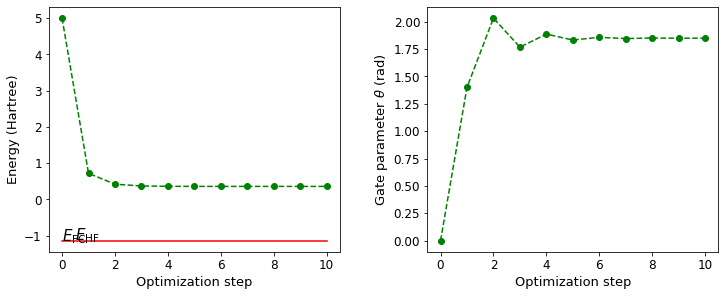

In [57]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()

In [58]:
angle[-1]

tensor(1.84943069, requires_grad=True)

In [59]:
energy[-1]

tensor(0.35994526, requires_grad=True)

In [60]:
l[-1]

(-5.211179975887232+0j)

In [61]:
np.sqrt(angle[-1]**2 + energy[-1]**2)

tensor(1.88413229, requires_grad=True)

In [63]:
print(l)

[19.68632047+0.j         1.26242975+1.2031351j  1.26242975-1.2031351j
 -5.21117998+0.j       ]


In this case, the VQE algorithm converges after thirteen iterations. The
optimal value of the circuit parameter $\theta^* = 0.208$ defines the
state

$$\vert \Psi(\theta^*) \rangle = 0.994~\vert 1100 \rangle - 0.104~\vert 0011 \rangle,$$

which is precisely the ground state of the $\mathrm{H}_2$ molecule in a
minimal basis set approximation.

Conclusion
==========

In this tutorial, we have implemented the VQE algorithm to find the
ground state of the hydrogen molecule. We used a simple circuit to
prepare quantum states of the molecule beyond the Hartree-Fock
approximation. The ground-state energy was obtained by minimizing a cost
function defined as the expectation value of the molecular Hamiltonian
in the trial state.

The VQE algorithm can be used to simulate other chemical phenomena. In
the tutorial `tutorial_vqe_bond_dissociation`{.interpreted-text
role="doc"}, we use VQE to explore the potential energy surface of
molecules to simulate chemical reactions. Another interesting
application is to probe the lowest-lying states of molecules in specific
sectors of the Hilbert space. For example, see the tutorial
`tutorial_vqe_spin_sectors`{.interpreted-text role="doc"}. Furthermore,
the algorithm presented here can be generalized to find the equilibrium
geometry of a molecule as it is demonstrated in the tutorial
`tutorial_mol_geo_opt`{.interpreted-text role="doc"}.

References {#vqe_references}
==========

About the author
================
